In [0]:
from torchtext import data,datasets
from torchtext.vocab import GloVe,FastText,CharNGram
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch
import sys

# Prepare Dataset

In [0]:
from torchtext import data

Text = data.Field(lower=True, batch_first=True, fix_length=20)
Label = data.Field(sequential=False)

In [5]:
from torchtext import datasets
train, test = datasets.IMDB.splits(Text, Label)

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:06<00:00, 13.9MB/s]


In [6]:
print(len(train))
train.fields

25000


{'label': <torchtext.data.field.Field at 0x7f0f5b9242e8>,
 'text': <torchtext.data.field.Field at 0x7f0f5b924278>}

# Build vocabulary

In [7]:
from torchtext.vocab import GloVe,FastText,CharNGram
Text.build_vocab(train, vectors=GloVe(name='6B', dim=300),max_size=10000,min_freq=10)
Label.build_vocab(train,)

.vector_cache/glove.6B.zip: 862MB [00:39, 21.6MB/s]                           
100%|█████████▉| 399821/400000 [00:38<00:00, 10582.13it/s]

# vectors

In [8]:
Text.vocab.vectors

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.7724, -0.1800,  0.2072,  ...,  0.6736,  0.2263, -0.2919],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])

# Build model

In [0]:
class EmbNet(nn.Module):
    def __init__(self,emb_size,hidden_size1,hidden_size2=400):
        super().__init__()
        self.embedding = nn.Embedding(emb_size,hidden_size1)
        self.fc1 = nn.Linear(hidden_size2,3)

        
    def forward(self,x):
        embeds = self.embedding(x).view(x.size(0),-1)
        out = self.fc1(embeds)
        return F.log_softmax(out,dim=-1)

In [0]:
model = EmbNet(len(Text.vocab.stoi),300,6000)
model = model.cuda()

# Loading pretrained Model

In [0]:
model.embedding.weight.data = Text.vocab.vectors.cuda()

# Freeze Model

In [0]:
model.embedding.weight.requires_grad = False

In [0]:
#optimizer = optim.SGD(model.parameters(),lr=0.001)
optimizer = optim.Adam([ param for param in model.parameters() if param.requires_grad == True],lr=0.001)

In [0]:
train_iter, test_iter = data.BucketIterator.splits((train, test), batch_size=64, device=None,shuffle=True)
train_iter.repeat = False
test_iter.repeat = False

In [0]:
def fit(epoch,model,data_loader,phase='training',volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx , batch in enumerate(data_loader):
        text , target = batch.text , batch.label
        text,target = text.cuda(),target.cuda()
        
        if phase == 'training':
            optimizer.zero_grad()
        output = model(text)
        loss = F.nll_loss(output,target)
        
        running_loss += F.nll_loss(output,target,size_average=False).item()
        preds = output.data.max(dim=1,keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    
    loss = running_loss/len(data_loader.dataset)
    accuracy = 100. * running_correct/len(data_loader.dataset)
    
    print("Phase: {}".format(phase),
         "\tLoss is: {}".format(loss),
         "\tAccuray: {}".format(accuracy))
    return loss,accuracy

In [35]:
train_losses , train_accuracy = [],[]
val_losses , val_accuracy = [],[]

for epoch in range(1,10):

    epoch_loss, epoch_accuracy = fit(epoch,model,train_iter,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_iter,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Phase: training 	Loss is: 0.6042271133422852 	Accuray: 67
Phase: validation 	Loss is: 0.6506933036804199 	Accuray: 63
Phase: training 	Loss is: 0.5851746073150634 	Accuray: 68
Phase: validation 	Loss is: 0.6586312265014649 	Accuray: 63
Phase: training 	Loss is: 0.5771122974395752 	Accuray: 69
Phase: validation 	Loss is: 0.6656799038696289 	Accuray: 63
Phase: training 	Loss is: 0.5660841520690918 	Accuray: 70
Phase: validation 	Loss is: 0.6762712435913086 	Accuray: 63
Phase: training 	Loss is: 0.5589513088226319 	Accuray: 70
Phase: validation 	Loss is: 0.6832228195953369 	Accuray: 63
Phase: training 	Loss is: 0.555998614730835 	Accuray: 70
Phase: validation 	Loss is: 0.6870256956481934 	Accuray: 62
Phase: training 	Loss is: 0.5501565885925292 	Accuray: 71
Phase: validation 	Loss is: 0.7041317966461181 	Accuray: 62
Phase: training 	Loss is: 0.5504335124206543 	Accuray: 71
Phase: validation 	Loss is: 0.6990523676300049 	Accuray: 62
Phase: training 	Loss is: 0.549692834854126 	Accuray: 71


In [38]:
len(train_losses), len(val_losses)

(9, 9)

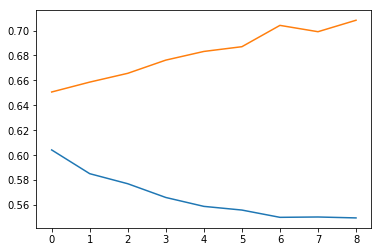

In [41]:
from matplotlib import pyplot as plt
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Training loss")

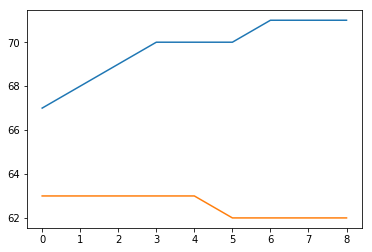

In [42]:
plt.plot(train_accuracy, label="Training loss")
plt.plot(val_accuracy, label="Training loss")

In [43]:
for epoch in range(1,10):

    epoch_loss, epoch_accuracy = fit(epoch,model,train_iter,phase='training')
    val_epoch_loss , val_epoch_accuracy = fit(epoch,model,test_iter,phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:46: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Phase: training 	Loss is: 0.5499911724090576 	Accuray: 71
Phase: validation 	Loss is: 0.715951830215454 	Accuray: 62
Phase: training 	Loss is: 0.5430210622406005 	Accuray: 72
Phase: validation 	Loss is: 0.7226534217834473 	Accuray: 62
Phase: training 	Loss is: 0.5442351079559327 	Accuray: 72
Phase: validation 	Loss is: 0.7180998049163818 	Accuray: 62
Phase: training 	Loss is: 0.5408957821655274 	Accuray: 72
Phase: validation 	Loss is: 0.7328949489593506 	Accuray: 62
Phase: training 	Loss is: 0.5379229023361206 	Accuray: 72
Phase: validation 	Loss is: 0.733945712890625 	Accuray: 61
Phase: training 	Loss is: 0.536673169631958 	Accuray: 72
Phase: validation 	Loss is: 0.73663930519104 	Accuray: 62
Phase: training 	Loss is: 0.5372424775695801 	Accuray: 72
Phase: validation 	Loss is: 0.7348388248443604 	Accuray: 62
Phase: training 	Loss is: 0.5364278735351562 	Accuray: 73
Phase: validation 	Loss is: 0.7449630688476563 	Accuray: 61
Phase: training 	Loss is: 0.5365013414764405 	Accuray: 72
Pha

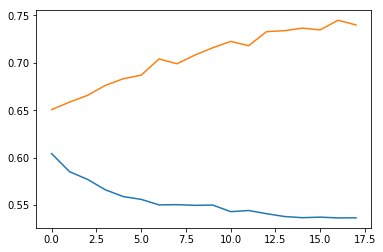

In [44]:
plt.plot(train_losses, label="Training loss")
plt.plot(val_losses, label="Training loss")

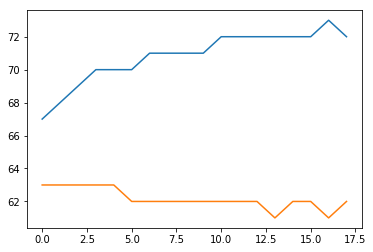

In [45]:
plt.plot(train_accuracy, label="Training loss")
plt.plot(val_accuracy, label="Training loss")